# Calculate speed metrics

In [74]:
import pandas as pd
import geopandas as gp
import osmnx as ox
import os

In [75]:
cols = ['uuid',
       'source', 
       'orig_id',
       'lat',
       'lon',
        'datetime_local',
       'sequence_id',
       'sequence_index']
df = pd.read_csv('./sample_data/02_metadata_common_attributes.csv')[cols]
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uuid            2319 non-null   object 
 1   source          2319 non-null   object 
 2   orig_id         2319 non-null   int64  
 3   lat             2319 non-null   float64
 4   lon             2319 non-null   float64
 5   datetime_local  2319 non-null   object 
 6   sequence_id     2319 non-null   object 
 7   sequence_index  2319 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 145.1+ KB


In [76]:
df.sequence_id.nunique()

29

## Calculate sequence distance

In [77]:
gdf = gp.GeoDataFrame(
    df, 
    geometry=gp.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

seqs = gdf['sequence_id'].unique().tolist()
len(seqs)

29

In [10]:
from tqdm.auto import tqdm
import threading
from pathlib import Path

def collect_proj_gdf(gdf, save_folder):
    proj = ox.project_gdf(gdf)
    gdf['easting'] = proj['geometry'].x
    gdf['northing'] = proj['geometry'].y
    gdf = gdf.sort_values('sequence_index', ascending=True)
    gdf['distance_from_prev'] = proj.distance(proj.shift(1))
    seqid = gdf['sequence_id'].unique()[0]
    gdf.drop(columns=['geometry']).to_csv(os.path.join(save_folder, str(seqid)+'.csv'), index=False)

def check_id(save_folder):
    ids = set()
    for name in os.listdir(save_folder):
        if name != '.DS_Store':
            ids.add(name.split('.')[0])
    return ids

save_folder = './sample_data/seqs_proj'
Path(save_folder).mkdir(parents=True, exist_ok=True)

threads = []
num_thread = 200
index = 0
alr_seqs = check_id(save_folder)

for seq in tqdm(seqs):
    
    if seq in alr_seqs:
        continue

    index += 1
    sub = gdf[gdf['sequence_id']==seq].sort_values('sequence_index', ascending=True)
    
    if index % num_thread == 0:
        print('Now:', index, len(seqs), 'already:', len(alr_seqs))
        t = threading.Thread(target=collect_proj_gdf, args=(sub, save_folder))
        threads.append(t)
        for t in threads:
            t.Daemon = True
            t.start()
        t.join()
        threads = []
    else:
        t = threading.Thread(target=collect_proj_gdf, args=(sub, save_folder))
        threads.append(t)
        
for t in threads:
    t.Daemon = True
    t.start()
t.join()

  0%|          | 0/29 [00:00<?, ?it/s]

In [78]:
projs = []
counter = 0
total = len([name for name in os.listdir(save_folder) if name!='.DS_Store'])
for file in os.listdir(save_folder):
    if file != '.DS_Store' and file != '.ipynb_checkpoints':
        counter += 1
        if counter%1000 == 0:
            print(counter, total)
        try:
            path = os.path.join(save_folder, file)
            proj = pd.read_csv(path)
            projs.append(proj)
        except Exception as e:
            print(e)
            print(file)

In [79]:
df_proj = pd.concat(projs, ignore_index=True)

In [80]:
df_proj['sequence_id'] = df_proj['sequence_id'].astype(str)
df_proj.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uuid                2319 non-null   object 
 1   source              2319 non-null   object 
 2   orig_id             2319 non-null   int64  
 3   lat                 2319 non-null   float64
 4   lon                 2319 non-null   float64
 5   datetime_local      2319 non-null   object 
 6   sequence_id         2319 non-null   object 
 7   sequence_index      2319 non-null   int64  
 8   easting             2319 non-null   float64
 9   northing            2319 non-null   float64
 10  distance_from_prev  2290 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 199.4+ KB


In [81]:
df_proj.head()

,uuid,source,orig_id,lat,lon,datetime_local,sequence_id,sequence_index,easting,northing,distance_from_prev
0,ef7c3bc0-47f4-468b-b76a-70c99c33be46,Mapillary,783278883996689,1.311614,103.814573,2024-06-23 12:00:35.355000+08:00,IpZomDBX9PL5TCucGgOek3,0,368116.487377,145004.284830,NaN
1,522422cc-4096-4609-b884-32b4a7e4fd4e,Mapillary,2229500610733814,1.311609,103.814541,2024-06-23 12:00:36.705000+08:00,IpZomDBX9PL5TCucGgOek3,1,368112.905705,145003.693622,3.630138
2,68395adf-eced-467a-9d28-ad8a50b13a26,Mapillary,781403850767945,1.311609,103.814519,2024-06-23 12:00:37.774000+08:00,IpZomDBX9PL5TCucGgOek3,2,368110.518111,145003.694753,2.387594
3,71717aa5-3e1e-442e-89fc-8d423b38e71b,Mapillary,2128689804166888,1.311609,103.814498,2024-06-23 12:00:39.068000+08:00,IpZomDBX9PL5TCucGgOek3,3,368108.130517,145003.695884,2.387594
4,ca266d9b-e1ab-4ec9-b86e-d472eb98ecc0,Mapillary,1741117416693014,1.311609,103.814498,2024-06-23 12:00:39.646000+08:00,IpZomDBX9PL5TCucGgOek3,4,368108.130517,145003.695884,0.000000


In [82]:
df_seq = df_proj.groupby('sequence_id').distance_from_prev.sum().reset_index().rename(columns={'distance_from_prev': 'seq_dist_m'})
df_seq

,sequence_id,seq_dist_m
0,1YXrVbZ2jh8FvpHzldW6wS,7.341284
1,2kFcjUgiThaAZ1Dl6x3Ond,29.492011
2,5UpKSNJezMsAho4Irt8aTd,11.754619
3,9073001,1780.825643
4,AHWuzGmO5vpPyk83hciZBr,72.390259
5,CetkzDNsXSc5ZYJvnriPIM,25.458641
6,Cp8PkABeHXaDxYiGbVhEmR,62.516400
7,Dxyqo2erpF58mQXUwtMWLJ,22.354212
8,IpZomDBX9PL5TCucGgOek3,103.603393
9,Jw7VROdnpD2BMjaQoLAFXe,902.788755


In [84]:
df_seq['seq_dist_km'] = df_seq['seq_dist_m']/1000
df_seq

,sequence_id,seq_dist_m,seq_dist_km
0,1YXrVbZ2jh8FvpHzldW6wS,7.341284,0.007341
1,2kFcjUgiThaAZ1Dl6x3Ond,29.492011,0.029492
2,5UpKSNJezMsAho4Irt8aTd,11.754619,0.011755
3,9073001,1780.825643,1.780826
4,AHWuzGmO5vpPyk83hciZBr,72.390259,0.072390
5,CetkzDNsXSc5ZYJvnriPIM,25.458641,0.025459
6,Cp8PkABeHXaDxYiGbVhEmR,62.516400,0.062516
7,Dxyqo2erpF58mQXUwtMWLJ,22.354212,0.022354
8,IpZomDBX9PL5TCucGgOek3,103.603393,0.103603
9,Jw7VROdnpD2BMjaQoLAFXe,902.788755,0.902789


In [85]:
df_seq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sequence_id  29 non-null     object 
 1   seq_dist_m   29 non-null     float64
 2   seq_dist_km  29 non-null     float64
dtypes: float64(2), object(1)
memory usage: 824.0+ bytes


## Calculate sequence time duration

In [86]:
df_proj.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uuid                2319 non-null   object 
 1   source              2319 non-null   object 
 2   orig_id             2319 non-null   int64  
 3   lat                 2319 non-null   float64
 4   lon                 2319 non-null   float64
 5   datetime_local      2319 non-null   object 
 6   sequence_id         2319 non-null   object 
 7   sequence_index      2319 non-null   int64  
 8   easting             2319 non-null   float64
 9   northing            2319 non-null   float64
 10  distance_from_prev  2290 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 199.4+ KB


In [87]:
d_seq = {seq: 0 for seq in df_proj['sequence_id'].unique().tolist()}

In [88]:
import datetime

counter = 0
for seq in d_seq.keys():
    counter += 1
    if counter%1000 == 0:
        print(counter, len(d_seq.keys()))
    temp = df_proj[df_proj['sequence_id'] == seq].reset_index(drop=True)
    t1 = temp.at[len(temp)-1, 'datetime_local']
    t2 = temp.at[0, 'datetime_local']
    dt1 = datetime.datetime.fromisoformat(t1)
    dt2 = datetime.datetime.fromisoformat(t2)
    delta = dt1-dt2
    timediff = delta.total_seconds()/3600
    d_seq[seq] = timediff

In [89]:
df_time = pd.DataFrame(list(d_seq.items())).rename(columns={
    0: 'sequence_id',
    1: 'seq_time_hr'
})
df_time

,sequence_id,seq_time_hr
0,IpZomDBX9PL5TCucGgOek3,0.020167
1,AHWuzGmO5vpPyk83hciZBr,0.015562
2,2kFcjUgiThaAZ1Dl6x3Ond,0.007123
3,Jw7VROdnpD2BMjaQoLAFXe,0.058060
4,O9eFWTxaRqVLU1BSZkMs43,0.009696
5,bECUqphZBujP6tx7mceRTg,0.008056
6,d2vjxPcuqg0EMDUHlVALzB,0.003927
7,sbhKcJIBmk58W1VYqrFi6Q,0.004663
8,9073001,0.145278
9,QtnRp5kUCqvXIhlbD6rOPi,0.007845


In [90]:
df_seq = df_seq.merge(df_time, on='sequence_id', how='left')
df_seq

,sequence_id,seq_dist_m,seq_dist_km,seq_time_hr
0,1YXrVbZ2jh8FvpHzldW6wS,7.341284,0.007341,0.003384
1,2kFcjUgiThaAZ1Dl6x3Ond,29.492011,0.029492,0.007123
2,5UpKSNJezMsAho4Irt8aTd,11.754619,0.011755,0.001472
3,9073001,1780.825643,1.780826,0.145278
4,AHWuzGmO5vpPyk83hciZBr,72.390259,0.072390,0.015562
5,CetkzDNsXSc5ZYJvnriPIM,25.458641,0.025459,0.004691
6,Cp8PkABeHXaDxYiGbVhEmR,62.516400,0.062516,0.013882
7,Dxyqo2erpF58mQXUwtMWLJ,22.354212,0.022354,0.004385
8,IpZomDBX9PL5TCucGgOek3,103.603393,0.103603,0.020167
9,Jw7VROdnpD2BMjaQoLAFXe,902.788755,0.902789,0.058060


In [91]:
df_seq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sequence_id  29 non-null     object 
 1   seq_dist_m   29 non-null     float64
 2   seq_dist_km  29 non-null     float64
 3   seq_time_hr  29 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.1+ KB


## Calculate sequence average speed

In [92]:
df_seq['seq_speed_kph'] = df_seq['seq_dist_km']/df_seq['seq_time_hr']
df_seq

,sequence_id,seq_dist_m,seq_dist_km,seq_time_hr,seq_speed_kph
0,1YXrVbZ2jh8FvpHzldW6wS,7.341284,0.007341,0.003384,2.169659
1,2kFcjUgiThaAZ1Dl6x3Ond,29.492011,0.029492,0.007123,4.140198
2,5UpKSNJezMsAho4Irt8aTd,11.754619,0.011755,0.001472,7.987284
3,9073001,1780.825643,1.780826,0.145278,12.258073
4,AHWuzGmO5vpPyk83hciZBr,72.390259,0.072390,0.015562,4.651583
5,CetkzDNsXSc5ZYJvnriPIM,25.458641,0.025459,0.004691,5.427639
6,Cp8PkABeHXaDxYiGbVhEmR,62.516400,0.062516,0.013882,4.503433
7,Dxyqo2erpF58mQXUwtMWLJ,22.354212,0.022354,0.004385,5.098205
8,IpZomDBX9PL5TCucGgOek3,103.603393,0.103603,0.020167,5.137358
9,Jw7VROdnpD2BMjaQoLAFXe,902.788755,0.902789,0.058060,15.549238


<AxesSubplot:>

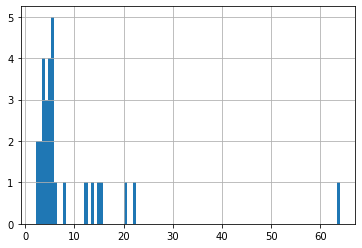

In [93]:
import numpy as np
df_seq[np.isfinite(df_seq['seq_speed_kph'])].seq_speed_kph.hist(bins=100)

In [94]:
df_seq[np.isfinite(df_seq['seq_speed_kph'])].seq_speed_kph.max()

64.03016979413012

## Merged sequence data to image data

In [95]:
df_seq[df_seq['seq_speed_kph'] == np.inf]

,sequence_id,seq_dist_m,seq_dist_km,seq_time_hr,seq_speed_kph


In [96]:
df_seq[df_seq['seq_speed_kph'].isnull()]

,sequence_id,seq_dist_m,seq_dist_km,seq_time_hr,seq_speed_kph


In [97]:
df_seq[df_seq['seq_speed_kph'] == 0]

,sequence_id,seq_dist_m,seq_dist_km,seq_time_hr,seq_speed_kph


In [98]:
df_seq[df_seq['seq_speed_kph'] < 0]

,sequence_id,seq_dist_m,seq_dist_km,seq_time_hr,seq_speed_kph


In [99]:
import numpy as np
# only valid sequences will retain the speed metrics
# valid sequences mean:
# speed is not null (null: dist = 0 and time duration = 0, e.g. only 1 image in the sequence), is finite (inf: dist > 0, time duration = 0), speed > 0 (speed < 0: time duration is negative), and speed <= 250 (very high speed values: positional error, wrong order)
seqs_valid = df_seq[np.isfinite(df_seq['seq_speed_kph'])]
seqs_valid = seqs_valid[seqs_valid['seq_speed_kph'] > 0]
seqs_valid = seqs_valid[seqs_valid['seq_speed_kph'] <= 250]

In [100]:
seqs_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sequence_id    29 non-null     object 
 1   seq_dist_m     29 non-null     float64
 2   seq_dist_km    29 non-null     float64
 3   seq_time_hr    29 non-null     float64
 4   seq_speed_kph  29 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.4+ KB


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   uuid            2319 non-null   object  
 1   source          2319 non-null   object  
 2   orig_id         2319 non-null   int64   
 3   lat             2319 non-null   float64 
 4   lon             2319 non-null   float64 
 5   datetime_local  2319 non-null   object  
 6   sequence_id     2319 non-null   object  
 7   sequence_index  2319 non-null   int64   
 8   geometry        2319 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 163.2+ KB


In [102]:
speed = df[['uuid', 'source', 'orig_id', 'sequence_id', 'sequence_index']]
speed = speed.merge(seqs_valid, on='sequence_id', how='left')
speed.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uuid            2319 non-null   object 
 1   source          2319 non-null   object 
 2   orig_id         2319 non-null   int64  
 3   sequence_id     2319 non-null   object 
 4   sequence_index  2319 non-null   int64  
 5   seq_dist_m      2319 non-null   float64
 6   seq_dist_km     2319 non-null   float64
 7   seq_time_hr     2319 non-null   float64
 8   seq_speed_kph   2319 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 181.2+ KB


## Calculate number of images per sequence

In [103]:
img_cnt = speed.groupby('sequence_id').uuid.count().to_frame(name="seq_img_count").reset_index()
img_cnt

,sequence_id,seq_img_count
0,1YXrVbZ2jh8FvpHzldW6wS,6
1,2kFcjUgiThaAZ1Dl6x3Ond,26
2,5UpKSNJezMsAho4Irt8aTd,8
3,9073001,427
4,AHWuzGmO5vpPyk83hciZBr,50
5,CetkzDNsXSc5ZYJvnriPIM,18
6,Cp8PkABeHXaDxYiGbVhEmR,36
7,Dxyqo2erpF58mQXUwtMWLJ,9
8,IpZomDBX9PL5TCucGgOek3,55
9,Jw7VROdnpD2BMjaQoLAFXe,161


In [104]:
img_cnt[img_cnt['seq_img_count'] == 1]

,sequence_id,seq_img_count


In [105]:
speed = speed.merge(img_cnt, on='sequence_id', how='left')
speed

,uuid,source,orig_id,sequence_id,sequence_index,seq_dist_m,seq_dist_km,seq_time_hr,seq_speed_kph,seq_img_count
0,d39b5e69-6291-46fc-a2f8-5947a7e024ee,Mapillary,1666317524185318,aE5o7bTMH0UtscOYxhVwID,1330,2054.616314,2.054616,0.101416,20.259269,660
1,07968c89-5a2a-4913-a870-7eaab4830be5,Mapillary,1014949793367409,aE5o7bTMH0UtscOYxhVwID,1586,2054.616314,2.054616,0.101416,20.259269,660
2,f8be9181-606c-4f23-88c5-2608d6cdea7b,Mapillary,2762100457273030,VWRknQTjyX4sEMFlL8CP7h,25,302.044443,0.302044,0.013571,22.255971,50
3,b9929935-7b0c-4c57-aca5-8f01fa37ee8b,Mapillary,1165840751204664,Jw7VROdnpD2BMjaQoLAFXe,222,902.788755,0.902789,0.058060,15.549238,161
4,c10b66a3-68bd-4dcf-9a86-6b17806e1dfc,Mapillary,1517629215831295,aE5o7bTMH0UtscOYxhVwID,1169,2054.616314,2.054616,0.101416,20.259269,660
...,...,...,...,...,...,...,...,...,...,...
2314,b7af09a0-6596-4514-a359-1b9bffd52377,KartaView,1994442313,9073001,1565,1780.825643,1.780826,0.145278,12.258073,427
2315,aa367724-e6e9-46d0-b38c-a6fc2cecfe37,KartaView,1994442329,9073001,1556,1780.825643,1.780826,0.145278,12.258073,427
2316,8200e3f5-9c4c-4bbe-867d-912d29eef7d7,KartaView,1994442345,9073001,1563,1780.825643,1.780826,0.145278,12.258073,427
2317,c34a52df-5a62-44d7-beac-56712c669cef,KartaView,1994442409,9073001,1562,1780.825643,1.780826,0.145278,12.258073,427


## Calculate variance, maximum, mean of segment speeds
Segment speed refers to the average speed along the interval travelled between each pair of consecutive points in a sequence (avg_speed_from_prev_kph).

In [106]:
df_proj.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uuid                2319 non-null   object 
 1   source              2319 non-null   object 
 2   orig_id             2319 non-null   int64  
 3   lat                 2319 non-null   float64
 4   lon                 2319 non-null   float64
 5   datetime_local      2319 non-null   object 
 6   sequence_id         2319 non-null   object 
 7   sequence_index      2319 non-null   int64  
 8   easting             2319 non-null   float64
 9   northing            2319 non-null   float64
 10  distance_from_prev  2290 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 199.4+ KB


In [107]:
seqids = df_proj['sequence_id'].unique().tolist()

In [108]:
df_proj = df_proj.rename(columns={'distance_from_prev': 'distance_from_prev_m'})
df_proj['distance_from_prev_km'] = df_proj['distance_from_prev_m']/1000
df_proj.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   2319 non-null   object 
 1   source                 2319 non-null   object 
 2   orig_id                2319 non-null   int64  
 3   lat                    2319 non-null   float64
 4   lon                    2319 non-null   float64
 5   datetime_local         2319 non-null   object 
 6   sequence_id            2319 non-null   object 
 7   sequence_index         2319 non-null   int64  
 8   easting                2319 non-null   float64
 9   northing               2319 non-null   float64
 10  distance_from_prev_m   2290 non-null   float64
 11  distance_from_prev_km  2290 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 217.5+ KB


In [109]:
import datetime
from tqdm import tqdm

ls = []
d_stats = {
    'sequence_id': [],
    'segmt_speed_mean_kph': [],
    'segmt_speed_var_kph2': [],
    'segmt_speed_max_kph': [],
    'segmt_speed_max5_mean_kph': []
}

for seqid in tqdm(seqids):
    
    df_sub = df_proj[df_proj['sequence_id'] == seqid]
    df_sub['dt'] = df_sub['datetime_local'].apply(lambda x: datetime.datetime.fromisoformat(x))
    df_sub['time_from_prev_s'] = df_sub.dt.diff()
    df_sub['time_from_prev_s'] = df_sub['time_from_prev_s'].apply(lambda x: x.total_seconds())
    df_sub['time_from_prev_hr'] = df_sub['time_from_prev_s']/3600
    df_sub['avg_speed_from_prev_kph'] = df_sub['distance_from_prev_km']/df_sub['time_from_prev_hr']
    
    mean = df_sub['avg_speed_from_prev_kph'].replace(np.inf, np.nan).mean(skipna=True)
    var = df_sub['avg_speed_from_prev_kph'].replace(np.inf, np.nan).var(skipna=True)
    maxi = df_sub['avg_speed_from_prev_kph'].replace(np.inf, np.nan).max(skipna=True)
    maxi5 = np.nan
    if len(df_sub) > 5:
        maxi5 = df_sub['avg_speed_from_prev_kph'].replace(np.inf, np.nan).sort_values(ascending=False)[:5].mean()
    
    d_stats['sequence_id'].append(seqid) # sequence id
    d_stats['segmt_speed_mean_kph'].append(mean) # mean of all segment speeds in the sequence
    d_stats['segmt_speed_var_kph2'].append(var) # variance of all segment speeds in the sequence
    d_stats['segmt_speed_max_kph'].append(maxi) # maximum segment speed in the sequence
    d_stats['segmt_speed_max5_mean_kph'].append(maxi5) # mean of the top 5 segment speeds in the sequence
    
    ls.append(df_sub)

  0%|                                                                       | 0/29 [00:00<?, ?it/s]/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_22418/1037994532.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['dt'] = df_sub['datetime_local'].apply(lambda x: datetime.datetime.fromisoformat(x))
/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_22418/1037994532.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['time_from_prev_s'] = df_sub.dt.diff()
/var/folders/q9/z

In [110]:
segmt_speed = pd.concat(ls).reset_index(drop=True)
segmt_speed.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uuid                     2319 non-null   object 
 1   source                   2319 non-null   object 
 2   orig_id                  2319 non-null   int64  
 3   lat                      2319 non-null   float64
 4   lon                      2319 non-null   float64
 5   datetime_local           2319 non-null   object 
 6   sequence_id              2319 non-null   object 
 7   sequence_index           2319 non-null   int64  
 8   easting                  2319 non-null   float64
 9   northing                 2319 non-null   float64
 10  distance_from_prev_m     2290 non-null   float64
 11  distance_from_prev_km    2290 non-null   float64
 12  dt                       2319 non-null   object 
 13  time_from_prev_s         2290 non-null   float64
 14  time_from_prev_hr       

In [111]:
segmt_speed['sequence_id'] = segmt_speed['sequence_id'].astype(str)

In [112]:
seq_stat = pd.DataFrame.from_dict(d_stats).rename(columns={'sequenceId': 'sequence_id'})
seq_stat

,sequence_id,segmt_speed_mean_kph,segmt_speed_var_kph2,segmt_speed_max_kph,segmt_speed_max5_mean_kph
0,IpZomDBX9PL5TCucGgOek3,5.295350,11.294143,13.930523,11.855012
1,AHWuzGmO5vpPyk83hciZBr,5.183589,19.837894,14.846309,13.326455
2,2kFcjUgiThaAZ1Dl6x3Ond,4.148467,14.711574,11.182204,9.681654
3,Jw7VROdnpD2BMjaQoLAFXe,19.339898,56.494060,38.055887,34.508251
4,O9eFWTxaRqVLU1BSZkMs43,5.261424,7.919047,12.078948,9.243676
5,bECUqphZBujP6tx7mceRTg,5.130884,19.850680,14.896898,12.223318
6,d2vjxPcuqg0EMDUHlVALzB,6.606628,10.713009,12.985027,8.923707
7,sbhKcJIBmk58W1VYqrFi6Q,3.797934,5.666919,8.169366,6.761444
8,9073001,13.925007,82.182749,26.939991,26.300514
9,QtnRp5kUCqvXIhlbD6rOPi,5.006360,17.912175,14.491680,11.798509


In [113]:
segmt_speed = segmt_speed.merge(seq_stat, on='sequence_id', how='left')
segmt_speed.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   uuid                       2319 non-null   object 
 1   source                     2319 non-null   object 
 2   orig_id                    2319 non-null   int64  
 3   lat                        2319 non-null   float64
 4   lon                        2319 non-null   float64
 5   datetime_local             2319 non-null   object 
 6   sequence_id                2319 non-null   object 
 7   sequence_index             2319 non-null   int64  
 8   easting                    2319 non-null   float64
 9   northing                   2319 non-null   float64
 10  distance_from_prev_m       2290 non-null   float64
 11  distance_from_prev_km      2290 non-null   float64
 12  dt                         2319 non-null   object 
 13  time_from_prev_s           2290 non-null   float

In [114]:
speed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uuid            2319 non-null   object 
 1   source          2319 non-null   object 
 2   orig_id         2319 non-null   int64  
 3   sequence_id     2319 non-null   object 
 4   sequence_index  2319 non-null   int64  
 5   seq_dist_m      2319 non-null   float64
 6   seq_dist_km     2319 non-null   float64
 7   seq_time_hr     2319 non-null   float64
 8   seq_speed_kph   2319 non-null   float64
 9   seq_img_count   2319 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 199.3+ KB


In [115]:
segmt_speed = segmt_speed.merge(speed.drop(columns=['source', 'orig_id', 'sequence_id', 'sequence_index']), on='uuid', how='left')
segmt_speed.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   uuid                       2319 non-null   object 
 1   source                     2319 non-null   object 
 2   orig_id                    2319 non-null   int64  
 3   lat                        2319 non-null   float64
 4   lon                        2319 non-null   float64
 5   datetime_local             2319 non-null   object 
 6   sequence_id                2319 non-null   object 
 7   sequence_index             2319 non-null   int64  
 8   easting                    2319 non-null   float64
 9   northing                   2319 non-null   float64
 10  distance_from_prev_m       2290 non-null   float64
 11  distance_from_prev_km      2290 non-null   float64
 12  dt                         2319 non-null   object 
 13  time_from_prev_s           2290 non-null   float

In [116]:
cols = ['uuid',
 'source',
 'orig_id',
 'seq_dist_m',
 'seq_dist_km',
 'seq_time_hr',
 'seq_speed_kph',
 'seq_img_count',
 'segmt_speed_mean_kph',
 'segmt_speed_var_kph2',
 'segmt_speed_max_kph',
 'segmt_speed_max5_mean_kph',
 'distance_from_prev_m',
 'distance_from_prev_km',
 'time_from_prev_s',
 'time_from_prev_hr',
 'avg_speed_from_prev_kph']
segmt_speed = segmt_speed[cols]
segmt_speed.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   uuid                       2319 non-null   object 
 1   source                     2319 non-null   object 
 2   orig_id                    2319 non-null   int64  
 3   seq_dist_m                 2319 non-null   float64
 4   seq_dist_km                2319 non-null   float64
 5   seq_time_hr                2319 non-null   float64
 6   seq_speed_kph              2319 non-null   float64
 7   seq_img_count              2319 non-null   int64  
 8   segmt_speed_mean_kph       2319 non-null   float64
 9   segmt_speed_var_kph2       2319 non-null   float64
 10  segmt_speed_max_kph        2319 non-null   float64
 11  segmt_speed_max5_mean_kph  2315 non-null   float64
 12  distance_from_prev_m       2290 non-null   float64
 13  distance_from_prev_km      2290 non-null   float

In [118]:
segmt_speed.to_csv('./sample_data/09_speed.csv', index=False)